# **Water Quality Model**
This is a notebook contains the development the neural network model,
I used **L1 regularization** with a coefficient of 0.01 to penalize large weights and reduce model complexity, and **The dropout rate** was set to 0.3 across all layers to randomly deactivate neurons during training, for preventing overfitting. For optimization, I chose **the Adam optimizer**with a learning rate of 0.001. Additionally, I implemented early stopping with a patience of 5 epochs to halt training if the validation loss did not improve, ensuring the model generalizes well to unseen data. These choices were made to balance model complexity, training efficiency, and generalization performance.

# Water Quality Dataset
This dataset contains water quality measurements and assessments related to potability, which is the suitability of water for human consumption. The dataset's primary objective is to provide insights into water quality parameters and assist in determining whether the water is potable or not. Each row in the dataset represents a water sample with specific attributes, and the "Potability" column indicates whether the water is suitable for consumption.

https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability?select=water_potability.csv

# **Data Loading and Preprocessing**

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("/content/water_potability.csv")
data.head(-10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3261,3.629922,244.187392,24856.633209,6.618071,366.967873,442.076337,13.302880,59.489294,4.754826,1
3262,8.378108,198.511213,28474.202580,6.477057,319.477187,499.866994,15.389083,35.221200,4.524693,1
3263,6.923636,260.593154,24792.525623,5.501164,332.232177,607.773567,15.483027,51.535867,4.013339,1
3264,5.893103,239.269481,20526.666156,6.349561,341.256362,403.617560,18.963707,63.846319,4.390702,1


In [8]:

# Check for missing values
print(data.isnull().sum())

# Fill missing values with the median of the column
data.fillna(data.median(), inplace=True)

# Split into features (X) and target (y)
X = data.drop("Potability", axis=1)
y = data["Potability"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (70%), validation (15%), and testing sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
Training set shape: (2293, 9) (2293,)
Validation set shape: (491, 9) (491,)
Testing set shape: (492, 9) (492,)


# **Model Architecture**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compute class weights to handle class imbalance
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

# Compile the model with Adam optimizer and learning rate 0.001
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [10]:
# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,  # Applying class weights
    callbacks=[early_stopping]
)





Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4900 - loss: 4.5779 - val_accuracy: 0.5560 - val_loss: 3.3297
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5490 - loss: 2.9800 - val_accuracy: 0.6232 - val_loss: 2.0364
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5493 - loss: 1.7939 - val_accuracy: 0.6375 - val_loss: 1.1828
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5723 - loss: 1.0596 - val_accuracy: 0.6314 - val_loss: 0.8118
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4542 - loss: 0.7832 - val_accuracy: 0.6314 - val_loss: 0.7141
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4646 - loss: 0.7096 - val_accuracy: 0.3686 - val_loss: 0.7004
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4536 - loss: 0.7011 - val_accuracy: 0.3686 - val_loss: 0.6980
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4648 - loss: 0.6957 - val_accuracy: 0.3686 - val_loss:

# **Model Evaluation**

In [11]:
# Evaluate the model on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.3).astype(int)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6211 - loss: 0.6959
Test Loss: 0.6958698034286499
Test Accuracy: 0.6239837408065796
Test Precision: 0.37601626016260165
Test Recall: 1.0
Test F1 Score: 0.5465288035450517


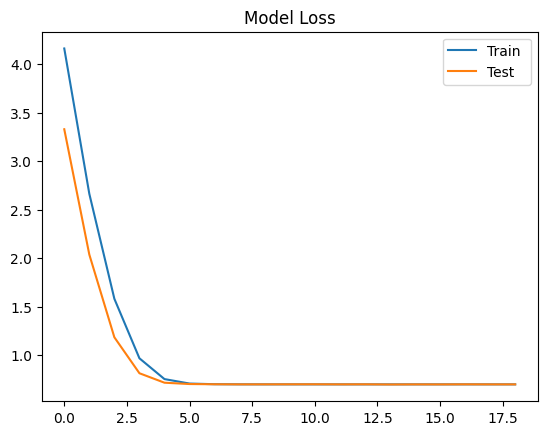

In [12]:
# plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train ')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.legend()
plt.show()



# My Model Performance and Comparison

My achieved a test accuracy of 62.4%, with a precision of 0.376, recall of 1.0, and an F1 score of 0.547, prioritized recall (1.0), meaning it successfully identified all actual potable water samples, but this came at the cost of precision (0.37), meaning it misclassified some non-potable samples as drinkablehad due to using L1 regularization which encouraged sparsity, potentially causing instability and early stopping privented overfitting but it might have halted training early, preventing the model from reaching its full potential and fully learned from the data.

 Compared to Shobi's model, which achieved a higher accuracy (70.6%) and F1 score (0.559), my model underperforms in precision and overall accuracy. However, my model outperforms Jean Chrisostome's model, which has a lower F1 score (0.3401) and recall (0.2258). The high recall in my model suggests it is better at identifying positive cases, but the low precision indicates a need for better calibration or feature engineering to reduce false positives. Improvements could include experimenting with different regularization techniques, adjusting the dropout rate, and tuning the learning rate further to achieve a better balance between precision and recall.